In [4]:
import pandas as pd 
from tqdm import tqdm
import csv
import math
import seaborn as sns
from sklearn.cluster import HDBSCAN

In [2]:
def read_csv_with_progress(file_path, chunksize=100000):
    """
    Reads a CSV file with a progress bar.

    Parameters:
    - file_path: Path to the CSV file.
    - chunksize: Number of rows per chunk.

    Returns:
    - DataFrame containing the concatenated chunks.
    """
    # Get the total number of lines in the file for the progress bar
    # This can be time-consuming for very large files
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        total = sum(1 for _ in f)

    # Initialize the progress bar
    progress_bar = tqdm(total=total, desc="Reading CSV", unit="lines")

    # Initialize an empty list to hold chunks
    chunks = []

    # Read the CSV file in chunks
    for chunk in pd.read_csv(file_path, chunksize=chunksize, iterator=True, encoding='utf-8'):
        chunks.append(chunk)
        progress_bar.update(len(chunk))

    # Close the progress bar
    progress_bar.close()

    # Concatenate all chunks into a single DataFrame
    df = pd.concat(chunks, ignore_index=True)

    return df

In [3]:
df = read_csv_with_progress("../processed_data/taxi_data_processed.csv")

NameError: name 'tqdm' is not defined

In [13]:
df = pd.read_csv("../processed_data/taxi_data_processed.csv")

In [3]:
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])

In [4]:
df['WEEKDAY'] = df['TIMESTAMP'].dt.weekday
df['TIME'] = df['TIMESTAMP'].dt.hour 

In [5]:
grouped = df.groupby(['WEEKDAY', 'TIME'])

In [6]:
sub_dfs = [group for name, group in grouped]

In [7]:
print(len(sub_dfs))

168


In [12]:
# Initialize lists to store updated sub-DataFrames
updated_sub_dfs = []
n_subframes = 168

# Iterate through each sub-DataFrame
for idx, sub_df in tqdm(enumerate(sub_dfs, start=1)):
    # print(f"\nProcessing Sub-DataFrame {idx}/{n_subframes}")
    
    # Calculate the number of origin points
    Cnt_origin = sub_df[['Long', 'Lat']].dropna().shape[0]
    MinPts_origin = math.ceil(math.log(Cnt_origin)) if Cnt_origin > 0 else 1
    
    # Calculate the number of destination points
    Cnt_dest = sub_df[['END_LONG', 'END_LAT']].dropna().shape[0]
    MinPts_dest = math.ceil(math.log(Cnt_dest)) if Cnt_dest > 0 else 1
    
    # Apply HDBSCAN to Origin Points if MinPts > 1
    if MinPts_origin > 1 and Cnt_origin >= MinPts_origin:
        origin_clusterer = HDBSCAN(min_samples=MinPts_origin, min_cluster_size=MinPts_origin)
        origin_coords = sub_df[['Long', 'Lat']].dropna().values
        origin_labels = origin_clusterer.fit_predict(origin_coords)
        origin_DOM = origin_clusterer.probabilities_
        
        # Assign the cluster labels and DOM back to the sub-DataFrame
        sub_df.loc[sub_df[['Long', 'Lat']].notnull().all(axis=1), 'Origin_Cluster'] = origin_labels
        sub_df.loc[sub_df[['Long', 'Lat']].notnull().all(axis=1), 'Origin_DOM'] = origin_DOM
    else:
        # Assign default values if clustering is not applicable
        sub_df['Origin_Cluster'] = -1
        sub_df['Origin_DOM'] = 0.0
        
    # Apply HDBSCAN to Destination Points if MinPts > 1
    if MinPts_dest > 1 and Cnt_dest >= MinPts_dest:
        dest_clusterer = HDBSCAN(min_samples=MinPts_dest, min_cluster_size=MinPts_dest)
        dest_coords = sub_df[['END_LONG', 'END_LAT']].dropna().values
        dest_labels = dest_clusterer.fit_predict(dest_coords)
        dest_DOM = dest_clusterer.probabilities_
        
        # Assign the cluster labels and DOM back to the sub-DataFrame
        sub_df.loc[sub_df[['END_LONG', 'END_LAT']].notnull().all(axis=1), 'Destination_Cluster'] = dest_labels
        sub_df.loc[sub_df[['END_LONG', 'END_LAT']].notnull().all(axis=1), 'Destination_DOM'] = dest_DOM
    else:
        # Assign default values if clustering is not applicable
        sub_df['Destination_Cluster'] = -1
        sub_df['Destination_DOM'] = 0.0
    
    # Append the updated sub-DataFrame to the list
    updated_sub_dfs.append(sub_df)

print("\nClustering completed for all sub-DataFrames.")

168it [00:02, 73.09it/s]


Clustering completed for all sub-DataFrames.


In [9]:
# Concatenate all updated sub-DataFrames into a single DataFrame
clustered_df = pd.concat(updated_sub_dfs)

# Reset index if necessary
clustered_df.reset_index(drop=True, inplace=True)

# Display the updated DataFrame
# print(clustered_df.head())

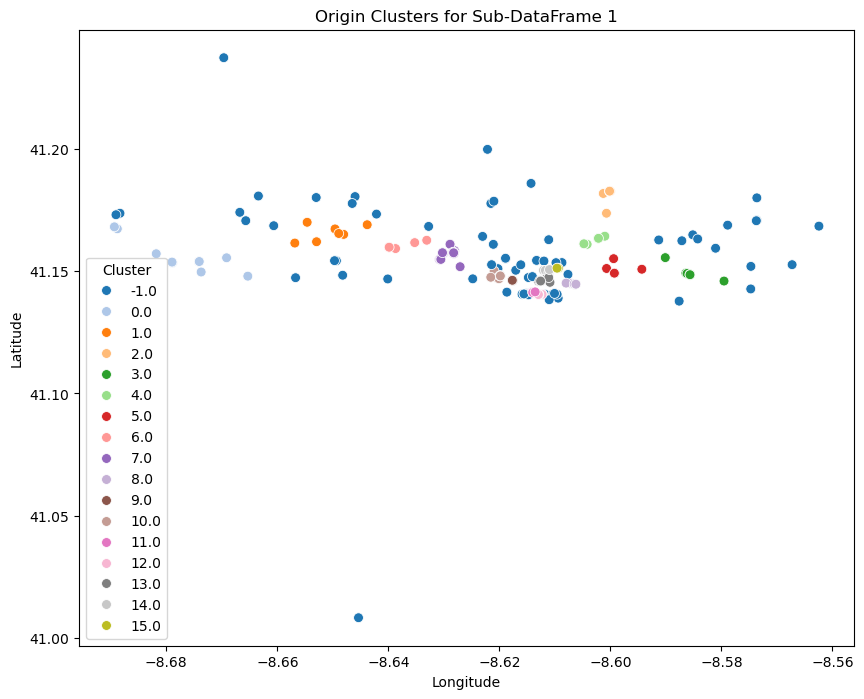

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Plotting Origin Clusters for a Sub-DataFrame
sub_df = updated_sub_dfs[0]  # First sub-DataFrame

plt.figure(figsize=(10, 8))
sns.scatterplot(data=sub_df, x='Long', y='Lat', hue='Origin_Cluster', palette='tab20', legend='full', s=50)
plt.title('Origin Clusters for Sub-DataFrame 1')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster')
plt.show()

In [10]:
import folium
import numpy as np

num_clusters = 7

# Ensure 'Origin_Cluster' column contains integers
clustered_df['Origin_Cluster'] = clustered_df['Origin_Cluster'].astype(int)

# Calculate the maximum cluster value and add 1, ensuring the result is an integer
max_clusters = int(np.max(clustered_df['Origin_Cluster']) + 1)

# Generate the color palette
color_palette = sns.color_palette('tab20', num_clusters)

# Create a base map
base_map = folium.Map(location=[clustered_df['Lat'].mean(), clustered_df['Long'].mean()], zoom_start=12)

# Add origin clusters to the map
for _, row in clustered_df.iterrows():
    
    
    cluster = row['Origin_Cluster']
    folium.CircleMarker(
        location=[row['Lat'], row['Long']],
        radius=5,
        color=color_palette,
        fill=True,
        fill_color=color_palette,
        fill_opacity=0.6,
        popup=f"Trip ID: {row['TRIP_ID']}, Cluster: {row['Origin_Cluster']}"
    ).add_to(base_map)

In [11]:
base_map.save("origin_clusters.html")

In [31]:
subfiles = {}
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for day in weekdays:
    for time in range(24):
        subfiles[(day, time)] = []

In [33]:
for idx, trip in df.iterrows():
    day_of_the_week = trip['WEEKDAY']
    time_of_day = trip['TIME'].hour
    
    subfiles[(day_of_the_week, time_of_day)].append(trip) 
      

In [43]:
def write_to_csv(filename, trips):
    # Logic to write the trips (list of dictionaries) to a CSV file
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=trips[0].keys())
        writer.writeheader()
        for trip in trips:
            writer.writerow(trip)

In [ ]:
# Write each subfile to a separate CSV file
for (day, hour), trips in subfiles.items():
    # Create a unique filename for each (day, hour)
    filename = f"trips_day_{day}_hour_{hour}.csv"
    # Write the trips to the CSV file (assuming a function `write_to_csv`)
    write_to_csv(filename, trips)